# 07 — Basic Deep Learning
*A practical intro to deep learning building blocks you'll reuse in RL (policies, critics, world models).*

**What you'll learn**
- Neuron & activations (sigmoid, tanh, ReLU).  
- MLP for classification (training loop, decision boundary).  
- CNN for images (MNIST/Fashion-MNIST) with conv/pool layers.  
- Regularization (Dropout, Weight Decay) & Normalization (BatchNorm).  
- RL tie-ins: policies/critics, convolutional encoders for Atari, shared backbones.

> Tip: Read each **Theory** cell first for context, then the code cells.

## Setup

In [1]:
import math, time, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
device

device(type='mps')

## 1. Neuron & Activations

At the heart of every neural network lies the **neuron**, a simple computational unit that performs a weighted sum followed by a nonlinear transformation:

$$
y = \phi(w^\top x + b)
$$

where  
- $ x \in \mathbb{R}^d $ is the input vector,  
- $ w \in \mathbb{R}^d $ are learnable weights,  
- $ b $ is a bias term, and  
- $ \phi(\cdot) $ is the **activation function** introducing nonlinearity.

### Common Activation Functions
- **Sigmoid:**  
  $$
  \sigma(z) = \frac{1}{1 + e^{-z}}
  $$
  Squashes values into (0, 1); good for probabilities but can saturate, leading to vanishing gradients.

- **tanh:**  
  $$
  \tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
  $$
  Zero-centered but still saturates for large $|z|$.

- **ReLU (Rectified Linear Unit):**  
  $$
  \text{ReLU}(z) = \max(0, z)
  $$
  Sparse activations, faster convergence, and widely used — though "dead neurons" can occur when gradients become zero.

### From Neurons to Networks
Stacking layers of neurons forms a **Multilayer Perceptron (MLP)**:
$$
f(x) = W_L \,\phi(\cdots \phi(W_2\,\phi(W_1 x + b_1) + b_2)\cdots) + b_L
$$
Each layer learns progressively abstract features, enabling complex function approximation.

### RL Connection
- In **policy networks**, the neuron layers map states $s$ to action probabilities $ \pi_\theta(a|s) $.  
- In **value networks**, they estimate expected returns $V_\phi(s)$.  
- Nonlinear activations (especially ReLU/tanh) allow the agent to capture nonlinear dynamics, enabling more expressive representations of policies and environment models.

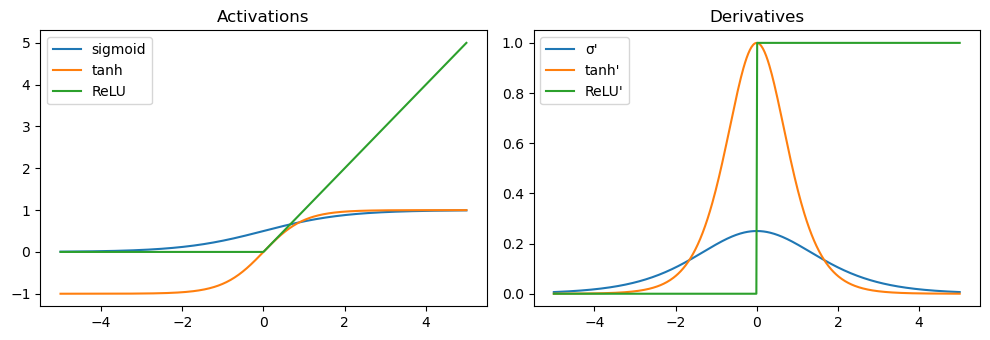

In [2]:
# Visualizing activations and their derivatives
z = np.linspace(-5, 5, 500)
def sigmoid(z): return 1/(1+np.exp(-z))
def dsigmoid(z): s=sigmoid(z); return s*(1-s)
def tanh(z): return np.tanh(z)
def dtanh(z): t=np.tanh(z); return 1-t**2
def relu(z): return np.maximum(0,z)
def drelu(z): return (z>0).astype(float)

plt.figure(figsize=(10,3.5))
plt.subplot(1,2,1)
plt.plot(z, sigmoid(z), label="sigmoid"); plt.plot(z, tanh(z), label="tanh"); plt.plot(z, relu(z), label="ReLU")
plt.title("Activations"); plt.legend()

plt.subplot(1,2,2)
plt.plot(z, dsigmoid(z), label="σ'"); plt.plot(z, dtanh(z), label="tanh'"); plt.plot(z, drelu(z), label="ReLU'")
plt.title("Derivatives"); plt.legend()
plt.tight_layout(); plt.show()

## 2. MLP Classification on Moons

A **Multilayer Perceptron (MLP)** learns a nonlinear mapping from inputs $ x $ to class probabilities $ p_\theta(y|x) $. It consists of stacked fully connected layers with activations such as ReLU or tanh, followed by a **softmax** output layer for classification:

$$
p_\theta(y=k|x) = \frac{e^{z_k}}{\sum_{j} e^{z_j}}, \quad \text{where } z = W_L h_{L-1} + b_L
$$

The network is trained by minimizing **cross-entropy loss**:
$$
\mathcal{L}(\theta) = -\frac{1}{N}\sum_{i=1}^{N} \log p_\theta(y_i|x_i)
$$

This encourages the model to assign high probability to the correct class for each sample.

### Practical Training Tips
- Use **mini-batches** to stabilize gradients and accelerate convergence.  
- Monitor **training vs validation loss** to detect overfitting.  
- Visualize **decision boundaries** to understand model behavior in low dimensions.

### Reinforcement Learning Connection
In RL, policy networks often share the same architecture:
$$
\pi_\theta(a|s) = \text{softmax}(W_2\,\phi(W_1 s + b_1) + b_2)
$$
where the MLP outputs probabilities over actions instead of class labels.  
Here, minimizing cross-entropy mirrors **maximizing policy likelihood** in policy gradient methods. Similarly, the critic network can be viewed as a regression MLP estimating value functions.

{'train': (0.18057496857643127, 0.9366666666666666), 'test': (0.14816934299468995, 0.94)}


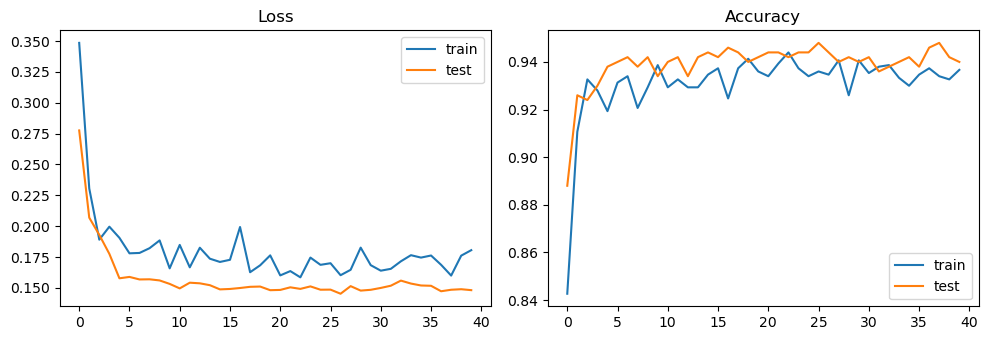

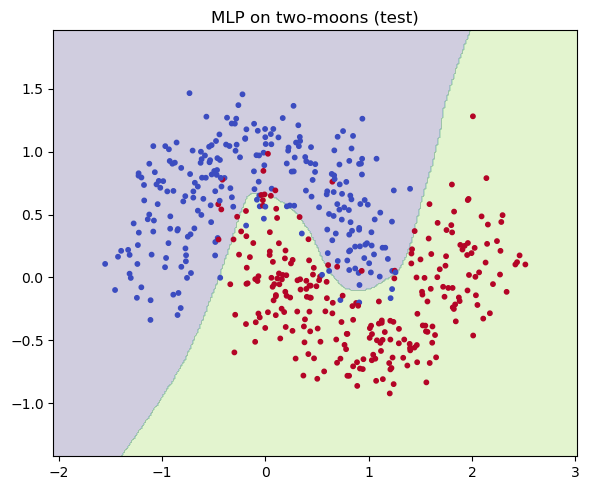

In [3]:
# Data: two-moons
X, y = make_moons(n_samples=2000, noise=0.25, random_state=0)
X = X.astype(np.float32); y = y.astype(np.int64)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
train_dl = DataLoader(TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)), batch_size=64, shuffle=True)
test_dl  = DataLoader(TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te)), batch_size=256, shuffle=False)

class MLP(nn.Module):
    def __init__(self, in_dim=2, hid=64, out_dim=2, pdrop=0.0, use_bn=False):
        super().__init__()
        layers = []
        layers += [nn.Linear(in_dim, hid)]
        if use_bn: layers += [nn.BatchNorm1d(hid)]
        layers += [nn.ReLU(), nn.Dropout(pdrop)]
        layers += [nn.Linear(hid, hid)]
        if use_bn: layers += [nn.BatchNorm1d(hid)]
        layers += [nn.ReLU(), nn.Dropout(pdrop)]
        layers += [nn.Linear(hid, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = MLP(pdrop=0.1, use_bn=True).to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4) # weight decay = L2
loss_fn = nn.CrossEntropyLoss()

def run_epoch(dl, train=True):
    model.train(train)
    total, correct, n = 0.0, 0, 0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        if train:
            opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item() * len(xb)
        correct += (logits.argmax(dim=1)==yb).sum().item()
        n += len(xb)
    return total/n, correct/n

train_hist, test_hist = [], []
for epoch in range(40):
    tr_loss, tr_acc = run_epoch(train_dl, train=True)
    te_loss, te_acc = run_epoch(test_dl,  train=False)
    train_hist.append((tr_loss, tr_acc)); test_hist.append((te_loss, te_acc))

print({"train": train_hist[-1], "test": test_hist[-1]})

# Curves
plt.figure(figsize=(10,3.5))
plt.subplot(1,2,1); plt.plot([l for l,_ in train_hist], label="train"); plt.plot([l for l,_ in test_hist], label="test")
plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot([a for _,a in train_hist], label="train"); plt.plot([a for _,a in test_hist], label="test")
plt.title("Accuracy"); plt.legend(); plt.tight_layout(); plt.show()

# Decision boundary
def plot_decision_boundary(model, X, y, title="Decision boundary"):
    model.eval()
    xv = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300)
    yv = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300)
    XX, YY = np.meshgrid(xv, yv)
    grid = torch.from_numpy(np.c_[XX.ravel(), YY.ravel()].astype(np.float32)).to(device)
    with torch.no_grad():
        zz = model(grid).argmax(1).view(XX.shape).cpu().numpy()
    plt.figure(figsize=(6,5))
    plt.contourf(XX, YY, zz, levels=2, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap="coolwarm")
    plt.title(title); plt.tight_layout(); plt.show()

plot_decision_boundary(model, X_te, y_te, "MLP on two-moons (test)")

## 3. CNN on MNIST

A **Convolutional Neural Network (CNN)** extends the MLP idea to spatial data (like images) by introducing **convolutions** — operations that exploit local spatial structure and reduce parameter count.

### Core Building Blocks
1. **Convolutional Layer:**
   Each neuron looks at a small *receptive field* and applies shared filters:
   $$
   y_{i,j,k} = \sum_{c} (W_{k,c} * X_c)_{i,j} + b_k
   $$
   where $ * $ denotes convolution, $W$ are learnable filters, and $b$ is bias.

2. **Pooling:**
   Reduces spatial size and increases translation invariance (e.g., MaxPool, AvgPool).

3. **Nonlinearity:**
   Applied after convolution — typically ReLU for fast and stable training.

4. **Fully Connected Layers:**
   After several conv+pool stages, flattened features feed into dense layers for classification.

### Why CNNs Work
- **Weight sharing:** The same filter is used across the entire image — fewer parameters, better generalization.  
- **Spatial hierarchy:** Lower layers learn edges/gradients; deeper ones capture shapes and objects.  
- **Translation tolerance:** Pooling and local connectivity make the network robust to small shifts.

### Reinforcement Learning Connection
- In **Atari-style RL**, agents observe raw pixels. CNNs act as **feature extractors**, mapping image frames $s_t$ → latent features $z_t$.  
- These features then feed into:
  - A **policy head** $ \pi_\theta(a|s) $ that outputs action probabilities.
  - A **value head** $ V_\phi(s) $ estimating expected return.  
- CNN encoders allow RL agents to learn from visual inputs directly, enabling breakthroughs in environments like Pong, Breakout, and DQN.

MNIST final: {'train': (0.03260704416930676, 0.9899), 'test': (0.030221648491127417, 0.9903)}


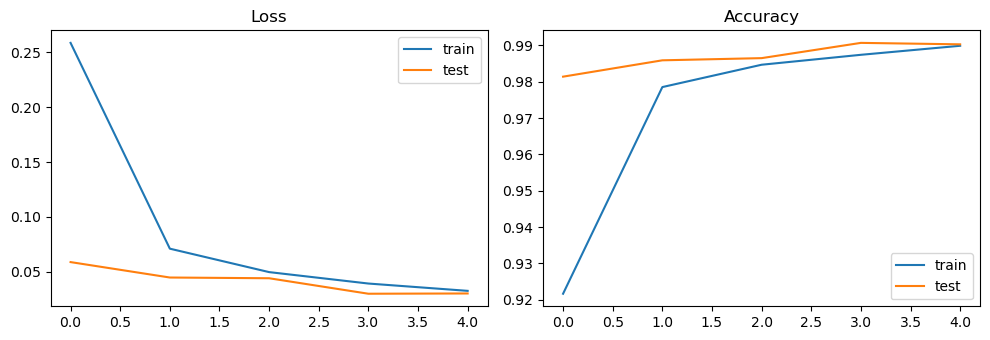

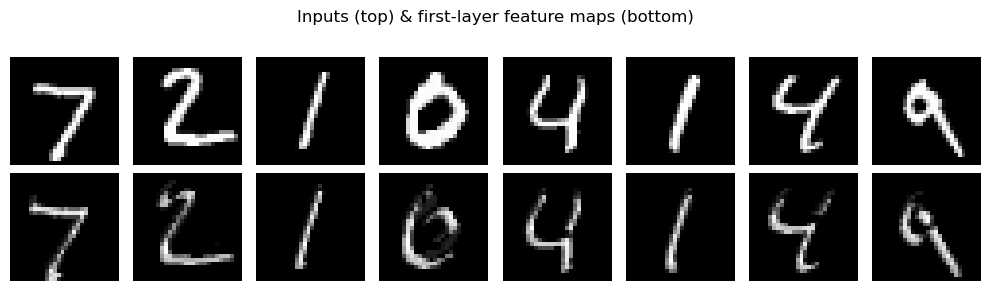

In [ ]:
# Minimal CNN on MNIST
import torchvision
from torchvision import transforms

tfm = transforms.Compose([transforms.ToTensor()])
train_ds = torchvision.datasets.MNIST(root="./data", train=True,  download=True, transform=tfm)
test_ds  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=0)

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2), # 14x14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2), # 7x7
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.head(self.feat(x))

cnn = SmallCNN().to(device)
opt_cnn = torch.optim.Adam(cnn.parameters(), lr=1e-3)
ce = nn.CrossEntropyLoss()

def epoch_loop(model, loader, train=True):
    model.train(train)
    total, correct, n = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = ce(logits, yb)
        if train:
            opt_cnn.zero_grad(); loss.backward(); opt_cnn.step()
        total += loss.item() * len(xb)
        correct += (logits.argmax(1)==yb).sum().item()
        n += len(xb)
    return total/n, correct/n

mnist_hist = {"train": [], "test": []}
for ep in range(5): # keep it light; bump to 10–15 for stronger accuracy
    tr = epoch_loop(cnn, train_loader, True)
    te = epoch_loop(cnn, test_loader,  False)
    mnist_hist["train"].append(tr); mnist_hist["test"].append(te)

print("MNIST final:", {"train": mnist_hist["train"][-1], "test": mnist_hist["test"][-1]})

plt.figure(figsize=(10,3.5))
plt.subplot(1,2,1); plt.plot([l for l,_ in mnist_hist["train"]], label="train"); plt.plot([l for l,_ in mnist_hist["test"]], label="test"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot([a for _,a in mnist_hist["train"]], label="train"); plt.plot([a for _,a in mnist_hist["test"]], label="test"); plt.title("Accuracy"); plt.legend()
plt.tight_layout(); plt.show()

# Peek feature maps
xb, yb = next(iter(test_loader))
xb = xb[:8].to(device)
with torch.no_grad():
    fm = cnn.feat[:2](xb) # after first Conv+ReLU
fm = fm.cpu().numpy()
plt.figure(figsize=(10,3))
for i in range(8):
    plt.subplot(2,8,i+1); plt.imshow(xb[i,0].cpu(), cmap="gray"); plt.axis("off")
    plt.subplot(2,8,8+i+1); plt.imshow(fm[i,0], cmap="gray"); plt.axis("off")
plt.suptitle("Inputs (top) & first-layer feature maps (bottom)")
plt.tight_layout(); plt.show()

## 4. Regularization & Normalization

Deep networks can easily **overfit** or suffer from **unstable optimization**. Regularization and normalization techniques mitigate these problems and improve generalization.

### Weight Decay (L2 Regularization)
Adds a penalty proportional to the squared magnitude of the weights:
$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{task}} + \lambda \|W\|_2^2
$$
This discourages large weights, improving numerical stability and reducing overfitting. Modern optimizers (e.g., **AdamW**) decouple weight decay from gradient updates for better control.

### Dropout
Randomly “drops” activations during training with probability $p$:
$$
h_i' = 
\begin{cases}
0, & \text{with prob } p,\\[6pt]
\frac{h_i}{1-p}, & \text{otherwise.}
\end{cases}
$$
This prevents neurons from co-adapting too strongly and acts as an implicit ensemble.

### Batch Normalization
Normalizes intermediate activations within each batch:
$$
\hat{x} = \frac{x - \mu_{\text{batch}}}{\sigma_{\text{batch}}}, \quad
y = \gamma \hat{x} + \beta
$$
This reduces **internal covariate shift**, leading to smoother gradients and faster convergence.

### RL Connection
- **Weight Decay**: used in nearly all deep RL architectures (DQN, PPO, SAC) for stability.  
- **Dropout**: helps in **policy regularization** and exploration in small fully connected nets.  
- **BatchNorm / LayerNorm**: stabilize feature distributions in **value critics** and **transformer-based policies**.  
  (For instance, PPO and Dreamer often use LayerNorm in latent models.)

> **In short:** Regularization prevents overfitting, normalization stabilizes learning — both are pillars of reliable deep and reinforcement learning.

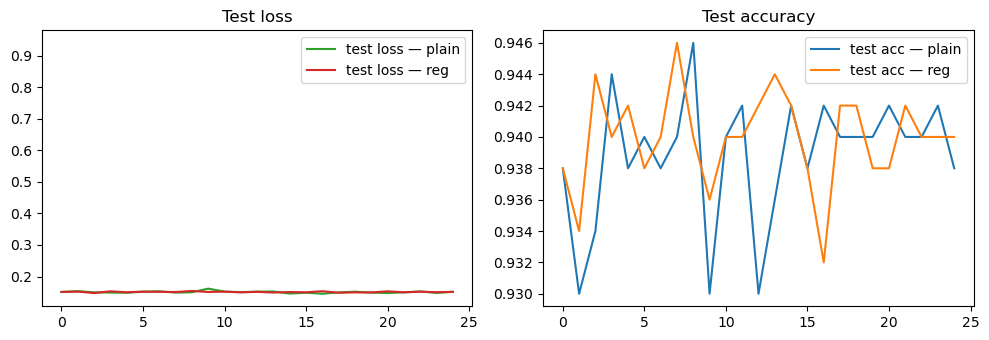

In [ ]:
# Quick comparison: MLP with/without Dropout & Weight Decay (two-moons)
def train_mlp(pdrop=0.0, wd=0.0):
    m = MLP(pdrop=pdrop, use_bn=False).to(device)
    optm = torch.optim.AdamW(m.parameters(), lr=3e-3, weight_decay=wd)
    hist=[]
    for ep in range(25):
        tr = run_epoch(DataLoader(TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)), batch_size=64, shuffle=True), True)
        te = run_epoch(DataLoader(TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te)), batch_size=256, shuffle=False), False)
        hist.append((tr, te))
    return m, hist

m_plain, h_plain = train_mlp(pdrop=0.0, wd=0.0)
m_reg,   h_reg   = train_mlp(pdrop=0.2, wd=1e-3)

plt.figure(figsize=(10,3.5))
plt.subplot(1,2,1)
plt.plot([te for (_,te) in [h_plain[-1], h_reg[-1]]], alpha=0) # spacer
plt.plot([l for l,_ in [x[1] for x in h_plain]], label="test loss — plain")
plt.plot([l for l,_ in [x[1] for x in h_reg]],   label="test loss — reg")
plt.title("Test loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot([a for _,a in [x[1] for x in h_plain]], label="test acc — plain")
plt.plot([a for _,a in [x[1] for x in h_reg]],   label="test acc — reg")
plt.title("Test accuracy"); plt.legend()
plt.tight_layout(); plt.show()


## Key Takeaways

- **Neurons & Activations:** ReLU/tanh give nonlinearity; choose activations to keep gradients healthy.  
- **MLPs & CNNs:** MLPs for low-dim states; CNNs for pixels. Training = forward → loss → backward → step.  
- **Regularization:** Weight decay, Dropout, and normalization improve generalization & stability.  
- **Direct RL relevance:** These modules become policy/critic heads and encoders in RL.

**Next:** `08_introduction_to_markov_chains.ipynb` → states, transitions, stationary distributions (foundation for MDPs).